<a href="https://colab.research.google.com/github/budoorhza/PROJECT363/blob/main/F2106601_2105535_SegmentationClassificationBrainMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Mada Ghurab 2105535

* Budoor Alarfaj 2106601

* dataset : https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation/data

In [1]:
import os
import zipfile
import glob
import json
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_zip_path = '/content/drive/MyDrive/363PROJECT/BTID.zip'
extracted_folder_path = '/content/BTID/'

In [4]:
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Dataset paths
train_path = os.path.join(extracted_folder_path, 'train/')
test_path = os.path.join(extracted_folder_path, 'test/')
valid_path = os.path.join(extracted_folder_path, 'valid/')

In [5]:
train_annotation = json.load(open('/content/BTID/train/_annotations.coco.json'))
test_annotation = json.load(open('/content/BTID/test/_annotations.coco.json'))
valid_annotation = json.load(open('/content/BTID/valid/_annotations.coco.json'))

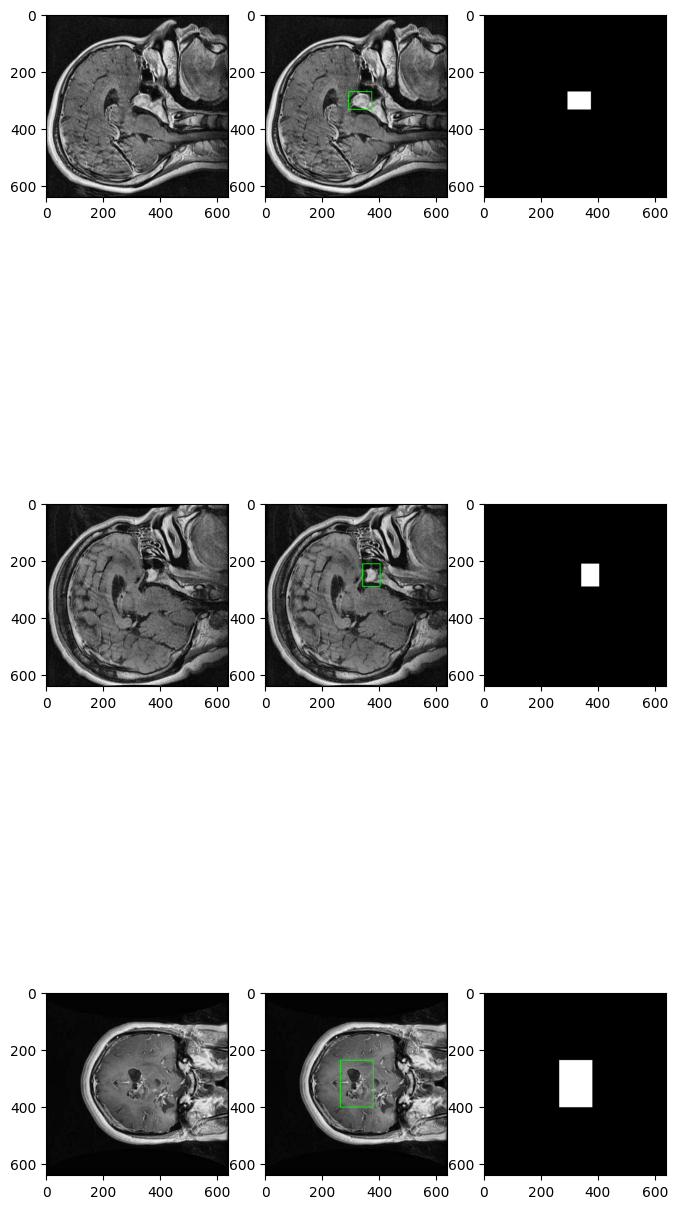

In [6]:
def visualize_random_images(n=3):  # select n random images
    indices = np.random.randint(0, len(train_annotation['images']), size=n)
    images = [train_annotation['images'][i] for i in indices]
    annotations = [train_annotation['annotations'][i] for i in indices]

    j = 1
    plt.figure(figsize=(8, 3 * 2 * n))
    for img, ann in zip(images, annotations):
        plt.subplot(n, 3, j)
        j += 1
        image = cv2.imread(os.path.join(train_path, img['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

        # create masked images from annotations
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

        plt.subplot(n, 3, j)
        plt.imshow(image)
        j += 1

        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=1)
        plt.subplot(n, 3, j)
        plt.imshow(mask, cmap='gray')
        j += 1

visualize_random_images()

In [7]:
def create_masks():
    def _create_masks_for_set(annotations, images_path, mask_dir):
        os.makedirs(mask_dir, exist_ok=True)
        total_images = len(annotations['images'])
        for img, ann in zip(annotations['images'], annotations['annotations']):
            path = os.path.join(images_path, img['file_name'])
            mask_path = os.path.join(mask_dir, img['file_name'])
            image = cv2.imread(path)
            segmentation = ann['segmentation']
            segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            cv2.fillPoly(mask, [segmentation], color=(255, 255, 255))
            cv2.imwrite(mask_path, mask)
            print(f"Processed {mask_path}")

    _create_masks_for_set(train_annotation, train_path, '/content/train_masks/')
    _create_masks_for_set(test_annotation, test_path, '/content/test_masks/')
    _create_masks_for_set(valid_annotation, valid_path, '/content/valid_masks/')

create_masks()

Processed /content/train_masks/2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg
Processed /content/train_masks/2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg
Processed /content/train_masks/2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg
Processed /content/train_masks/2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg
Processed /content/train_masks/2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg
Processed /content/train_masks/2161_jpg.rf.3be4125d1ffe011c0ed462d9fe0d2152.jpg
Processed /content/train_masks/2265_jpg.rf.3c62c7b8825039fab853256f9a9fe141.jpg
Processed /content/train_masks/1491_jpg.rf.3c658e83538de0fa5a3f4e13d7d85f12.jpg
Processed /content/train_masks/1385_jpg.rf.3c67cb92e2922dba0e6dba86f69df40b.jpg
Processed /content/train_masks/2534_jpg.rf.3c8c86666860368d46b8f7bcd95ac220.jpg
Processed /content/train_masks/2433_jpg.rf.3cdf8e4cb3a08e9b2fccc6c6082c2344.jpg
Processed /content/train_masks/1550_jpg.rf.3d067be9580ec32dbee5a89c675d8459.jpg
Processed /content/train_masks/2076_jpg.

In [8]:
def load_data():
    target_size = (128, 128)
    train_mask_dir = '/content/train_masks/'

    X_train = [cv2.resize(cv2.imread(os.path.join(train_path, image['file_name'])), target_size) for image in train_annotation['images']]
    y_train = [cv2.resize(cv2.imread(os.path.join(train_mask_dir, image['file_name']), cv2.IMREAD_GRAYSCALE), target_size) for image in train_annotation['images']]
    X_train = np.array(X_train)
    y_train = np.expand_dims(np.array(y_train), axis=-1)

    X_train = X_train.astype('float32') / 255.0
    y_train = y_train.astype('float32') / 255.0
    y_train = (y_train > 0.5).astype(np.float32)

    val_mask_dir = '/content/valid_masks/'
    X_val = [cv2.resize(cv2.imread(os.path.join(valid_path, image['file_name'])), target_size) for image in valid_annotation['images']]
    y_val = [cv2.resize(cv2.imread(os.path.join(val_mask_dir, image['file_name']), cv2.IMREAD_GRAYSCALE), target_size) for image in valid_annotation['images']]
    X_val = np.array(X_val)
    y_val = np.expand_dims(np.array(y_val), axis=-1)

    X_val = X_val.astype('float32') / 255.0
    y_val = y_val.astype('float32') / 255.0
    y_val = (y_val > 0.5).astype(np.float32)

    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = load_data()

In [9]:
def downsample_block(input_tensor, filters):
    f = layers.Conv2D(filters, (3, 3), padding="same")(input_tensor)
    f = layers.BatchNormalization()(f)
    f = layers.ReLU()(f)
    p = layers.MaxPooling2D((2, 2))(f)

    return f, p

def upsample_block(input_tensor, concat_tensor, filters):
    u = layers.Conv2D(filters, (3, 3), padding="same")(input_tensor)
    u = layers.BatchNormalization()(u)
    u = layers.ReLU()(u)
    u = layers.UpSampling2D((2, 2))(u)
    u = layers.concatenate([u, concat_tensor], axis=-1)

    return u

In [10]:
def build_unet_model():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = layers.Conv2D(1024, (3, 3), padding="same")(p4)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.ReLU()(bottleneck)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u9)

    model = tf.keras.Model(inputs, outputs, name="U-Net")
    return model

In [16]:
# Define Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

In [17]:
unet_model = build_unet_model()
unet_model.compile(optimizer="adam", loss=lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred),
                   metrics=["accuracy"])

unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 128, 128, 64)   │            256 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_9 (ReLU)            │ (None, 128, 128, 64)   │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ re_lu_9[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 64, 64, 128)    │            512 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_10 (ReLU)           │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ re_lu_10[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 32, 256)    │          1,024 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_11 (ReLU)           │ (None, 32, 32, 256)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 256)    │              0 │ re_lu_11[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 16, 16, 512)    │          2,048 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_12 (ReLU)      

 Total params: 14,098,625 (53.78 MB)

 Trainable params: 14,092,737 (53.76 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [18]:
# Train the model
earlystop = EarlyStopping(monitor='val_loss', patience=5)
unet_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[earlystop])

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 319ms/step - accuracy: 0.7285 - loss: 1.4648 - val_accuracy: 0.8415 - val_loss: 1.4547
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.9527 - loss: 0.8246 - val_accuracy: 0.8053 - val_loss: 1.4882
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.9606 - loss: 0.7164 - val_accuracy: 0.8543 - val_loss: 1.3157
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9645 - loss: 0.6437 - val_accuracy: 0.8577 - val_loss: 1.2903
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9675 - loss: 0.5933 - val_accuracy: 0.8814 - val_loss: 1.1892
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9697 - loss: 0.5582 - val_accuracy: 0.9535 - val_loss: 1.0856
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9715 - loss: 0.5265 - val_accuracy: 0.9550 - val_loss: 0.9908
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9729 - loss: 0.4991 - val_accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


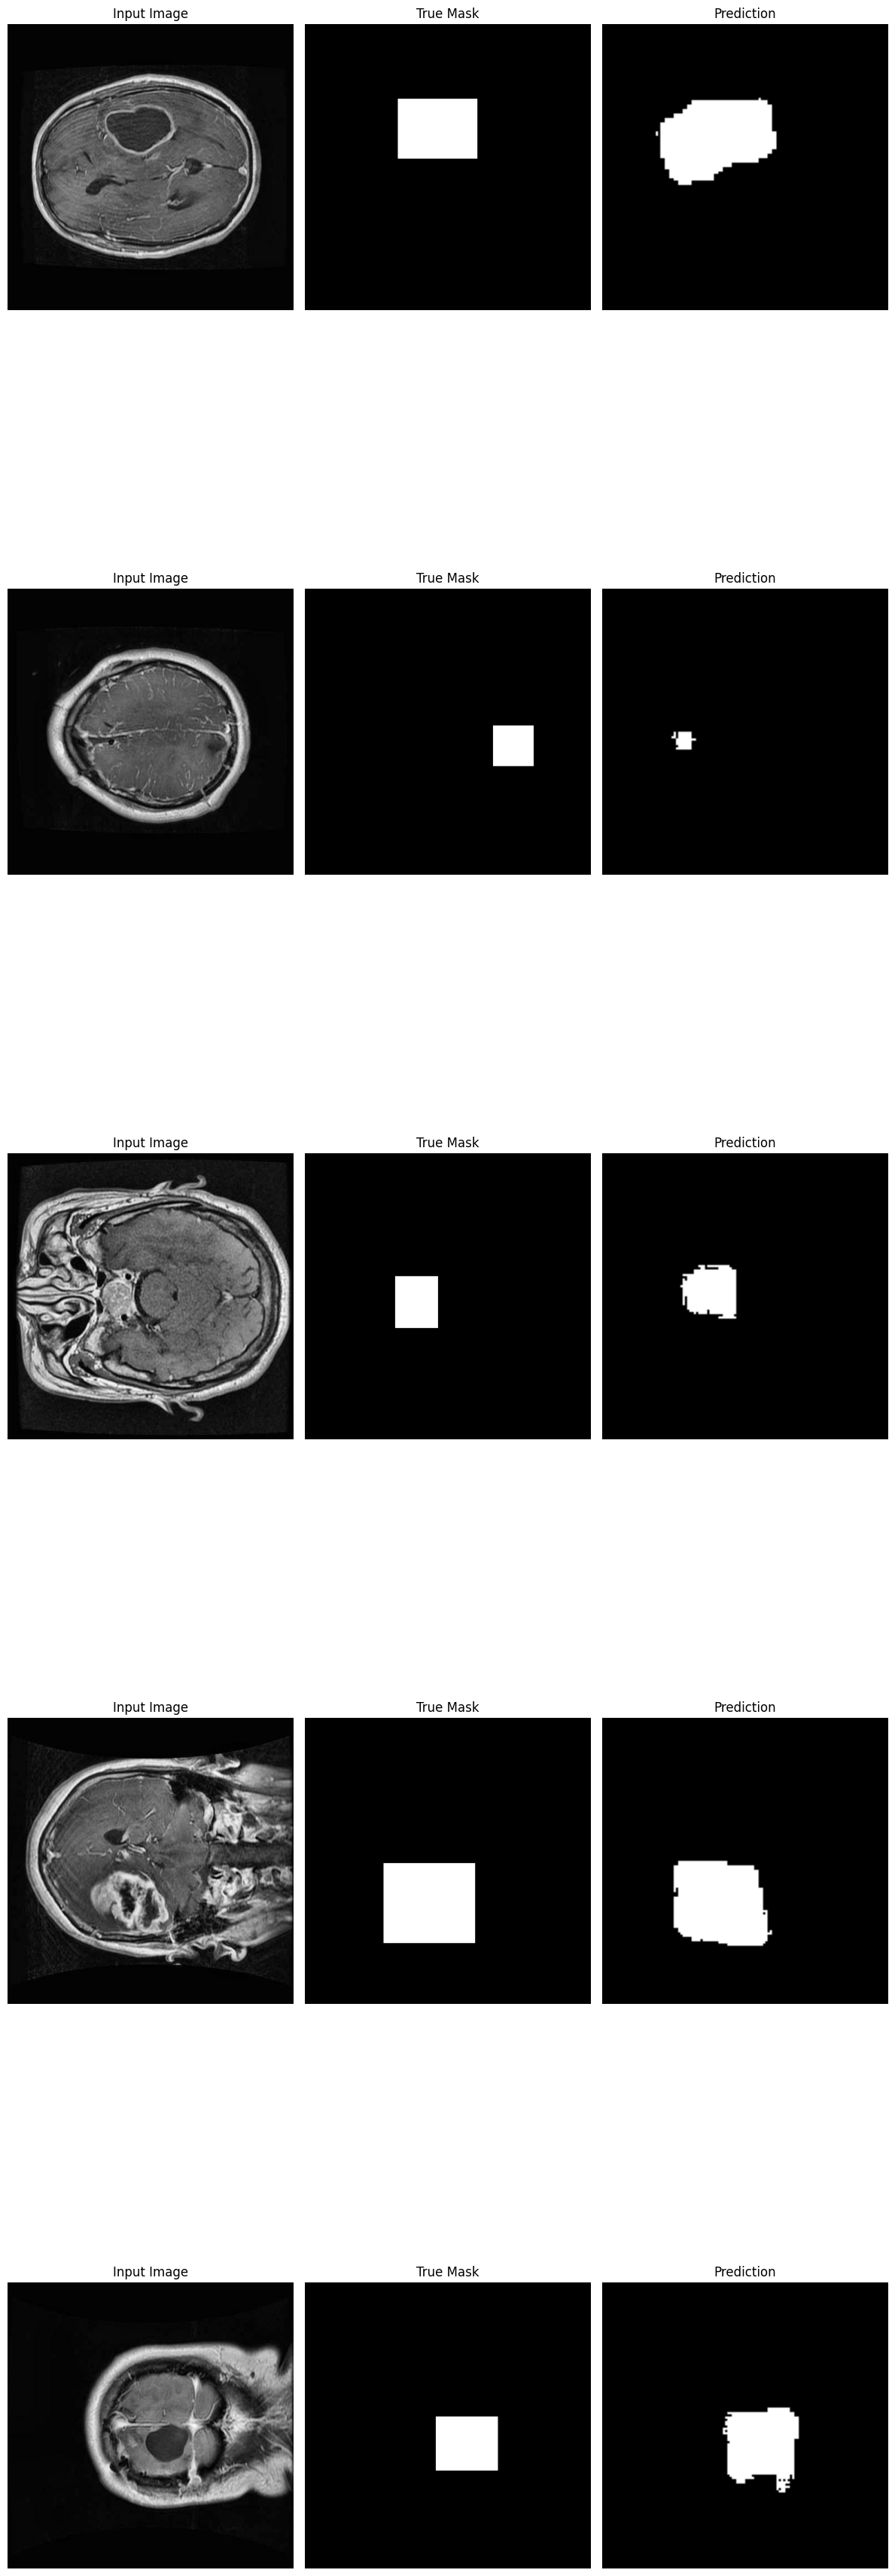

In [23]:
def predict(image_path, model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_resized = cv2.resize(image, (128, 128))

    image_expanded = np.expand_dims(image_resized, axis=0)

    image_normalized = image_expanded.astype('float32') / 255.0

    prediction = model.predict(image_normalized)

    prediction = (prediction > 0.5).astype(np.uint8)

    return prediction[0]

def test_random_images(n=5):
    indices = np.random.randint(0, len(test_annotation['images']), size=n)
    images = [test_annotation['images'][i] for i in indices]
    annotations = [test_annotation['annotations'][i] for i in indices]

    plt.figure(figsize=(12, 4 * 2 * n))

    for i, (img, ann) in enumerate(zip(images, annotations)):

        plt.subplot(n, 3, 3 * i + 1)
        image = cv2.imread(os.path.join(test_path, img['file_name']))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Input Image")
        plt.axis('off')

        true_mask = cv2.imread(os.path.join('/content/test_masks/', img['file_name']), cv2.IMREAD_GRAYSCALE)
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        mask = predict(os.path.join(test_path, img['file_name']), unet_model)
        result_image = np.zeros((128, 128, 1), dtype=np.uint8)
        result_image[mask == 1] = 255

        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(result_image, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

test_random_images(n=5)


In [ ]:
import os
import zipfile
import glob
import json
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
drive.mount('/content/drive')

dataset_zip_path = '/content/drive/MyDrive/363PROJECT/BTID.zip'
extracted_folder_path = '/content/BTID/'

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Dataset paths
train_path = os.path.join(extracted_folder_path, 'train/')
test_path = os.path.join(extracted_folder_path, 'test/')
valid_path = os.path.join(extracted_folder_path, 'valid/')

train_annotation = json.load(open('/content/BTID/train/_annotations.coco.json'))
test_annotation = json.load(open('/content/BTID/test/_annotations.coco.json'))
valid_annotation = json.load(open('/content/BTID/valid/_annotations.coco.json'))

def visualize_random_images(n=3):  # select n random images
    indices = np.random.randint(0, len(train_annotation['images']), size=n)
    images = [train_annotation['images'][i] for i in indices]
    annotations = [train_annotation['annotations'][i] for i in indices]

    j = 1
    plt.figure(figsize=(8, 3 * 2 * n))
    for img, ann in zip(images, annotations):
        plt.subplot(n, 3, j)
        j += 1
        image = cv2.imread(os.path.join(train_path, img['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

        # create masked images from annotations
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

        plt.subplot(n, 3, j)
        plt.imshow(image)
        j += 1

        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=1)
        plt.subplot(n, 3, j)
        plt.imshow(mask, cmap='gray')
        j += 1

visualize_random_images()

def create_masks():
    def _create_masks_for_set(annotations, images_path, mask_dir):
        os.makedirs(mask_dir, exist_ok=True)
        total_images = len(annotations['images'])
        for img, ann in zip(annotations['images'], annotations['annotations']):
            path = os.path.join(images_path, img['file_name'])
            mask_path = os.path.join(mask_dir, img['file_name'])
            image = cv2.imread(path)
            segmentation = ann['segmentation']
            segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            cv2.fillPoly(mask, [segmentation], color=(255, 255, 255))
            cv2.imwrite(mask_path, mask)
            print(f"Processed {mask_path}")

    _create_masks_for_set(train_annotation, train_path, '/content/train_masks/')
    _create_masks_for_set(test_annotation, test_path, '/content/test_masks/')
    _create_masks_for_set(valid_annotation, valid_path, '/content/valid_masks/')

create_masks()

def load_data():
    target_size = (128, 128)
    train_mask_dir = '/content/train_masks/'

    X_train = [cv2.resize(cv2.imread(os.path.join(train_path, image['file_name'])), target_size) for image in train_annotation['images']]
    y_train = [cv2.resize(cv2.imread(os.path.join(train_mask_dir, image['file_name']), cv2.IMREAD_GRAYSCALE), target_size) for image in train_annotation['images']]
    X_train = np.array(X_train)
    y_train = np.expand_dims(np.array(y_train), axis=-1)

    X_train = X_train.astype('float32') / 255.0
    y_train = y_train.astype('float32') / 255.0
    y_train = (y_train > 0.5).astype(np.float32)

    val_mask_dir = '/content/valid_masks/'
    X_val = [cv2.resize(cv2.imread(os.path.join(valid_path, image['file_name'])), target_size) for image in valid_annotation['images']]
    y_val = [cv2.resize(cv2.imread(os.path.join(val_mask_dir, image['file_name']), cv2.IMREAD_GRAYSCALE), target_size) for image in valid_annotation['images']]
    X_val = np.array(X_val)
    y_val = np.expand_dims(np.array(y_val), axis=-1)

    X_val = X_val.astype('float32') / 255.0
    y_val = y_val.astype('float32') / 255.0
    y_val = (y_val > 0.5).astype(np.float32)

    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = load_data()

def downsample_block(input_tensor, filters):
    # إنشاء طبقة Convolution تليها BatchNormalization و ReLU
    f = layers.Conv2D(filters, (3, 3), padding="same")(input_tensor)
    f = layers.BatchNormalization()(f)
    f = layers.ReLU()(f)

    # إنشاء طبقة MaxPooling لتقليص الأبعاد
    p = layers.MaxPooling2D((2, 2))(f)

    return f, p

def upsample_block(input_tensor, concat_tensor, filters):
    # طبقة Conv2D تليها BatchNormalization و ReLU
    u = layers.Conv2D(filters, (3, 3), padding="same")(input_tensor)
    u = layers.BatchNormalization()(u)
    u = layers.ReLU()(u)

    # طبقة Upsampling لزيادة الأبعاد
    u = layers.UpSampling2D((2, 2))(u)

    # دمجها مع الميزة القادمة من مرحلة التناقص (Skip connection)
    u = layers.concatenate([u, concat_tensor], axis=-1)

    return u

def build_unet_model():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = layers.Conv2D(1024, (3, 3), padding="same")(p4)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.ReLU()(bottleneck)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u9)

    model = tf.keras.Model(inputs, outputs, name="U-Net")
    return model

# Define Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())


unet_model = build_unet_model()
unet_model.compile(optimizer="adam", loss=lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred),
                   metrics=["accuracy"])

unet_model.summary()


# Train the model
earlystop = EarlyStopping(monitor='val_loss', patience=5)
unet_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[earlystop])



def predict(image_path, model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_resized = cv2.resize(image, (128, 128))

    image_expanded = np.expand_dims(image_resized, axis=0)

    image_normalized = image_expanded.astype('float32') / 255.0

    prediction = model.predict(image_normalized)

    prediction = (prediction > 0.5).astype(np.uint8)

    return prediction[0]

def test_random_images(n=5):
    indices = np.random.randint(0, len(test_annotation['images']), size=n)
    images = [test_annotation['images'][i] for i in indices]
    annotations = [test_annotation['annotations'][i] for i in indices]

    plt.figure(figsize=(12, 4 * 2 * n))

    for i, (img, ann) in enumerate(zip(images, annotations)):

        plt.subplot(n, 3, 3 * i + 1)
        image = cv2.imread(os.path.join(test_path, img['file_name']))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Input Image")
        plt.axis('off')

        true_mask = cv2.imread(os.path.join('/content/test_masks/', img['file_name']), cv2.IMREAD_GRAYSCALE)
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        mask = predict(os.path.join(test_path, img['file_name']), unet_model)
        result_image = np.zeros((128, 128, 1), dtype=np.uint8)
        result_image[mask == 1] = 255

        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(result_image, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

test_random_images(n=5)
